Import the Libraries and Modules

In [2]:
!pip install gym_super_mario_bros==7.3.0 nes_py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [4]:
# Install pytorch
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytor
# Install stable baselines for RL stuff
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytor
ERROR: Could not find a version that satisfies the requirement torch==1.10.1+cu113 (from versions: 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.2.0, 1.3.0, 1.3.1, 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1)
ERROR: No matching distribution found for torch==1.10.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

Preprocessing the Super Mario Game

In [6]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [7]:
# Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# Simplify the controls 
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [8]:
state = env.reset()

In [9]:
state, reward, done, info = env.step([5])

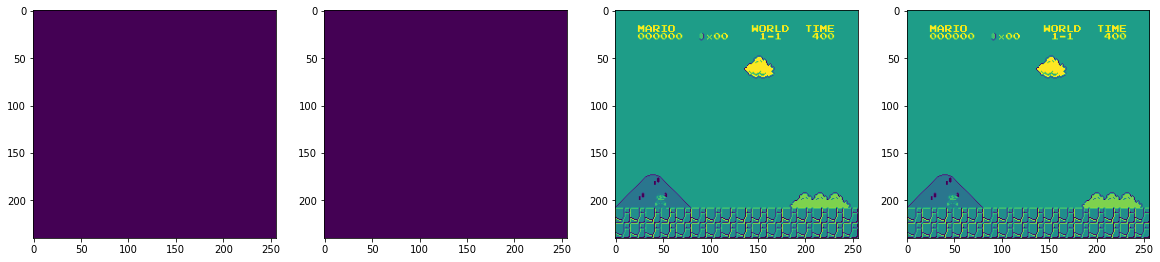

In [10]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

Creating the Model

In [11]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [12]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [13]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [14]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=5000, save_path=CHECKPOINT_DIR)

Training the AI Model

In [15]:
# This is the AI model started
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cuda device
Wrapping the env in a VecTransposeImage.


In [16]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=10000, callback=callback)

Logging to ./logs/PPO_3


/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 48  |
|    iterations      | 1   |
|    time_elapsed    | 10  |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 42            |
|    iterations           | 2             |
|    time_elapsed         | 24            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 3.9890292e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.00192      |
|    learning_rate        | 1e-06         |
|    loss                 | 131           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000154     |
|    value_loss           | 421           |
-------------------------------------------
-----

In [17]:
model.save('DLSModel')

Testing the Model

In [18]:
# Load model
model = PPO.load('./train/best_model_10000')

In [19]:
state = env.reset()

In [20]:
# Record Agent
from gym import wrappers

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = wrappers.Monitor(env, "./gym-results", force=True)
env.reset()
for _ in range(4000):
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    if done: break
env.close()

/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


In [22]:
import io
import base64
from IPython.display import HTML

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="420" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))